   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

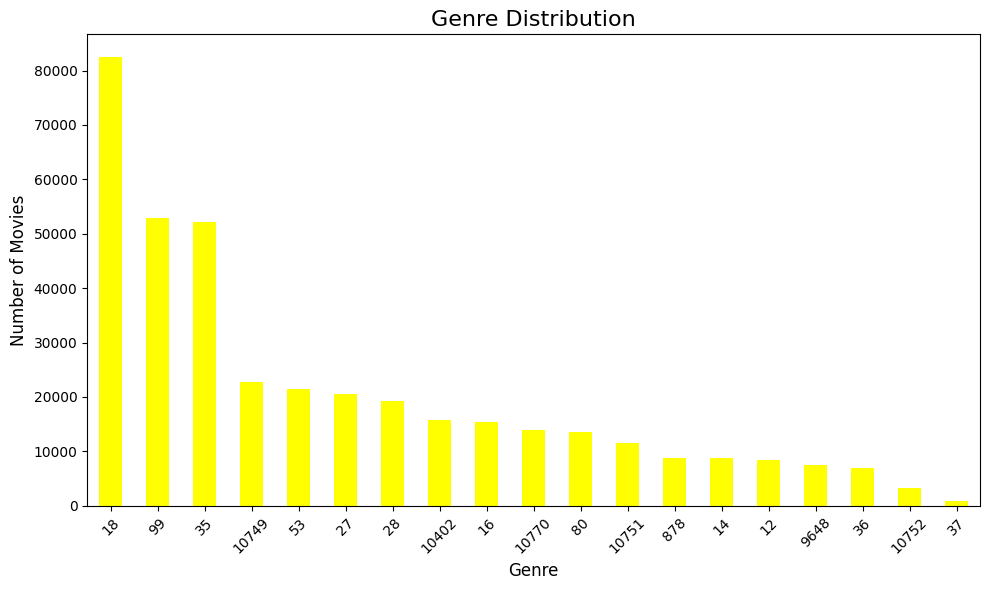

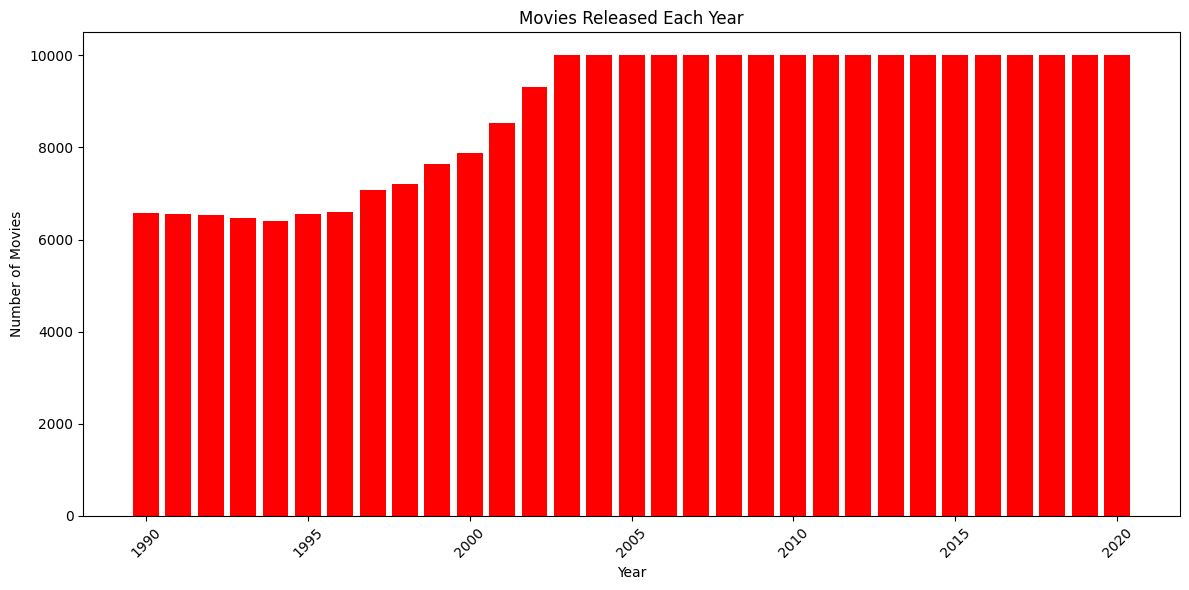

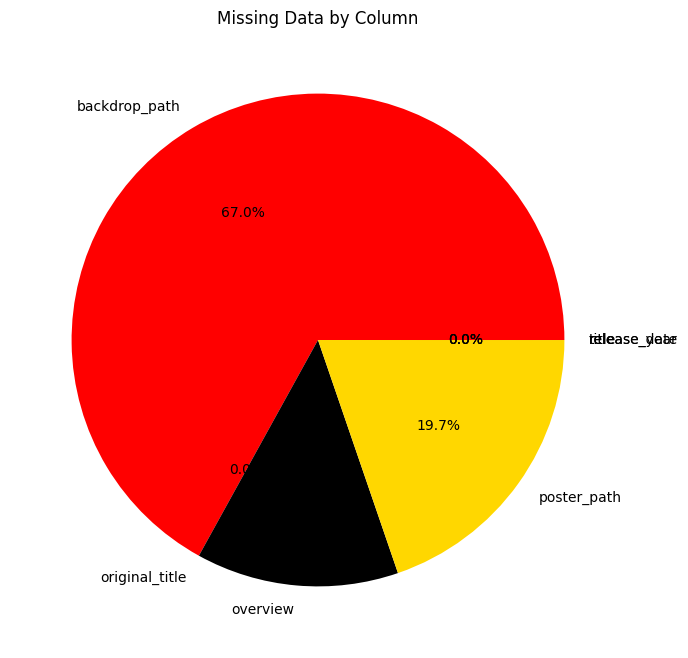

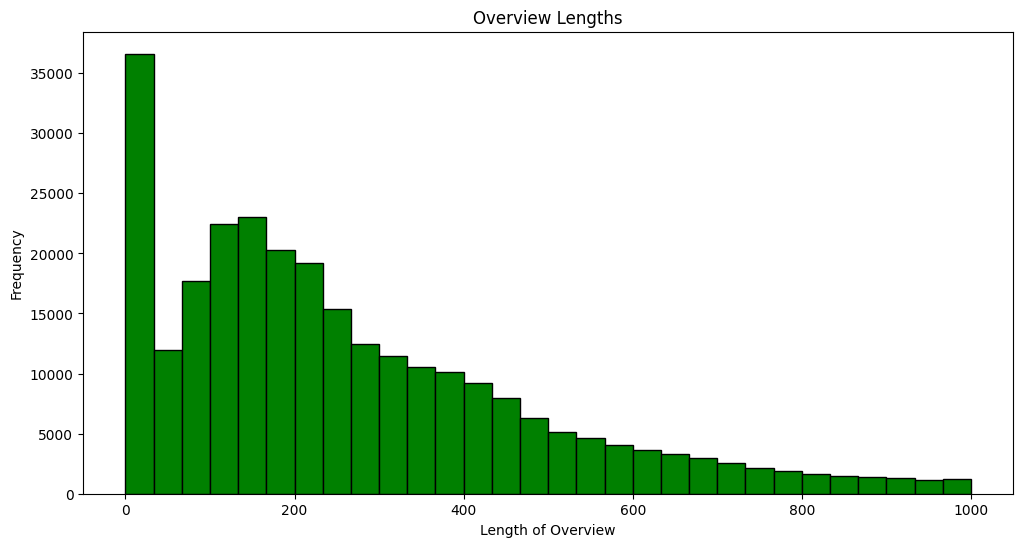

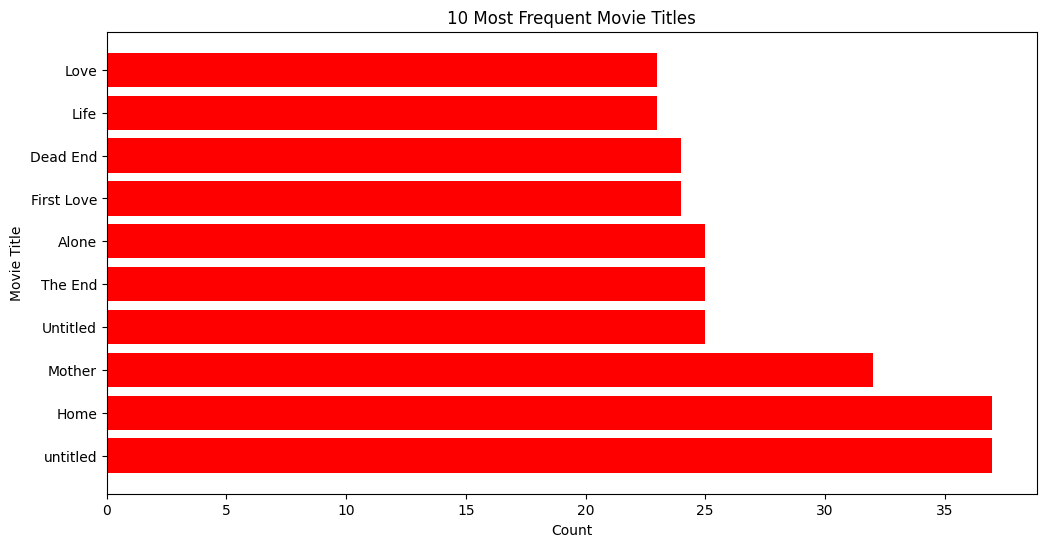

{'train_size': 121987,
 'val_size': 15248,
 'test_size': 15249,
 'num_genres': 19,
 'genre_classes': [12,
  14,
  16,
  18,
  27,
  28,
  35,
  36,
  37,
  53,
  80,
  99,
  878,
  9648,
  10402,
  10749,
  10751,
  10752,
  10770]}

In [1]:
# Role-1

!pip install requests pandas torch torchvision transformers

import time
import torch
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

def fetch_movies_for_year(api_key, year):
    movies = []
    page = 1
    while True:
        url = f'https://api.themoviedb.org/3/discover/movie?api_key={api_key}&page={page}&language=en-US&primary_release_year={year}'
        response = requests.get(url)
        data = response.json()

        if 'results' in data:
            movies.extend(data['results'])

            if page >= data.get('total_pages', 1) or len(movies) >= 10000:
                break
            page += 1
        else:
            print(f'Error fetching data for year {year}')
            break
        time.sleep(0.1)
    return movies

def get_movies(api_key, start_year, end_year):
    movies = []
    years = range(start_year, end_year + 1)
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_year = {executor.submit(fetch_movies_for_year, api_key, year): year for year in years}
        for future in as_completed(future_to_year):
            year = future_to_year[future]
            try:
                yearly_movies = future.result()
                for movie in yearly_movies:
                    movie['release_year'] = year  # Add release year
                movies.extend(yearly_movies)
                print(f'Fetched {len(yearly_movies)} movies for {year}')
            except Exception as exc:
                print(f'{year} generated an exception: {exc}')
    return movies

# --- Run the fetch ---
api_key = 'b4d3bebe67b3b8135ee1a697673dedca'
movies = get_movies(api_key, 1990, 2020)

# --- Save to CSV ---
df = pd.DataFrame(movies)
df.to_csv('new_movies.csv', index=False)
print(f"Total movies saved: {len(df)}")


df = pd.read_csv('new_movies.csv')

print(df.head())
print(df.info())

# Check for any missing values
missing_values = df.isnull().sum()
print(f"Missing values in each column: \n{missing_values}")

print(df.describe())

# Number of movies in each genre that we pulled
if 'genre_ids' in df.columns:
    genre_counts = df['genre_ids'].value_counts()
    print(f"Genre counts:\n{genre_counts}")

# Number of movies in release year
if 'release_date' in df.columns:
    df['release_year'] = pd.to_datetime(df['release_date']).dt.year
    print(df['release_year'].value_counts().sort_index())

df.columns

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('new_movies.csv')

# Ensure genre_ids is a list
import ast
df['genre_ids'] = df['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Flatten all genre IDs into one list
all_genres = [genre_id for sublist in df['genre_ids'] for genre_id in sublist]

# Count the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot the genre distribution
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='yellow')
plt.title("Genre Distribution", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


df = pd.read_csv('new_movies.csv')

df.columns = df.columns.str.strip()

#convert release_date to release_year using datetime
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

release_year_counts = df['release_year'].value_counts().sort_index()

# Plot the number of movies released each year
plt.figure(figsize=(12, 6))
plt.bar(release_year_counts.index, release_year_counts.values, color='red')

plt.title('Movies Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Check and count missing values in each column
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]

if not missing_data.empty:
    plt.figure(figsize=(8, 8))
    plt.pie(missing_data, labels=missing_data.index, autopct='%1.1f%%', colors=['red', 'green', 'black', 'gold', 'pink'])
    plt.title("Missing Data by Column")
    plt.show()
else:
    print("No missing data")


if 'overview' in df.columns:
    # Empty list to store the lengths of overviews
    overview_lengths = []

    # Loop through each movie's overview
    for overview in df['overview']:
        if isinstance(overview, str):
            overview_lengths.append(len(overview))
        else:
            overview_lengths.append(0)

    plt.figure(figsize=(12, 6))
    plt.hist(overview_lengths, bins=30, color='green', edgecolor='black')
    plt.title("Overview Lengths")
    plt.xlabel("Length of Overview")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("Error")


if 'title' in df.columns:
    # Count the number of times each title appears
    title_counts = {}

    for title in df['title']:
        if title in title_counts:
            title_counts[title] += 1
        else:
            title_counts[title] = 1

    # Sort the titles by frequency (in descending order)
    sorted_titles = sorted(title_counts.items(), key=lambda x: x[1], reverse=True)

    # Take the most frequent titles
    TitleAmount = 10
    top_titles = sorted_titles[:TitleAmount]

    titles = [x[0] for x in top_titles]
    counts = [x[1] for x in top_titles]

    plt.figure(figsize=(12, 6))
    plt.barh(titles, counts, color='red')
    plt.title(f"{TitleAmount} Most Frequent Movie Titles")
    plt.xlabel("Count")
    plt.ylabel("Movie Title")
    plt.show()
else:
    print("Error")


import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load the main dataset
df = pd.read_csv("new_movies.csv")

# === Clean & Preprocess ===

import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load full movie data
df = pd.read_csv("new_movies.csv")

# Filter for valid entries only
df = df.dropna(subset=["overview", "poster_path", "id"])
df = df.drop_duplicates(subset="id")  # ensure no repeat IDs

# Parse genre_ids
def safe_parse(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []

df["genre_ids"] = df["genre_ids"].apply(safe_parse)
df = df[df["genre_ids"].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Filter genre frequencies
flat_genres = [g for sublist in df["genre_ids"] for g in sublist]
valid_genres = pd.Series(flat_genres).value_counts()
valid_genres = valid_genres[valid_genres >= 20].index.tolist()
df["genre_ids"] = df["genre_ids"].apply(lambda x: [g for g in x if g in valid_genres])
df = df[df["genre_ids"].apply(lambda x: len(x) > 0)]

# Multi-label binarization
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df["genre_ids"])
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

# Final dataframe includes overview + genre labels + id + poster path
final_df = pd.concat([df[["id", "overview", "poster_path"]].reset_index(drop=True), genre_df.reset_index(drop=True)], axis=1)

# Split dataset
train_df, temp_df = train_test_split(final_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save corrected files (with id + poster_path now embedded!)
train_df.to_csv("train_clean_with_id.csv", index=False)
val_df.to_csv("val_clean_with_id.csv", index=False)
test_df.to_csv("test_clean_with_id.csv", index=False)


# Output stats
{
    "train_size": len(train_df),
    "val_size": len(val_df),
    "test_size": len(test_df),
    "num_genres": len(mlb.classes_),
    "genre_classes": mlb.classes_.tolist(),
}


Using device: cuda
Loading GloVe...
Loaded 400000 word vectors.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



===== Epoch 1/50 =====


Training Epoch 1: 100%|██████████| 954/954 [00:12<00:00, 78.44it/s]


Train Loss: 240.7002 | Val Loss: 26.1171 | Val Acc: 0.9189
 Best model saved!

===== Epoch 2/50 =====


Training Epoch 2: 100%|██████████| 954/954 [00:11<00:00, 86.51it/s]


Train Loss: 207.1049 | Val Loss: 25.7387 | Val Acc: 0.9195
 Best model saved!

===== Epoch 3/50 =====


Training Epoch 3: 100%|██████████| 954/954 [00:11<00:00, 86.41it/s]


Train Loss: 202.4569 | Val Loss: 25.4616 | Val Acc: 0.9203
 Best model saved!

===== Epoch 4/50 =====


Training Epoch 4: 100%|██████████| 954/954 [00:11<00:00, 86.42it/s]


Train Loss: 198.3460 | Val Loss: 24.2128 | Val Acc: 0.9235
 Best model saved!

===== Epoch 5/50 =====


Training Epoch 5: 100%|██████████| 954/954 [00:11<00:00, 85.49it/s]


Train Loss: 194.7722 | Val Loss: 24.3964 | Val Acc: 0.9229

===== Epoch 6/50 =====


Training Epoch 6: 100%|██████████| 954/954 [00:10<00:00, 87.22it/s]


Train Loss: 191.6239 | Val Loss: 23.6324 | Val Acc: 0.9250
 Best model saved!

===== Epoch 7/50 =====


Training Epoch 7: 100%|██████████| 954/954 [00:10<00:00, 86.89it/s]


Train Loss: 188.8987 | Val Loss: 23.4390 | Val Acc: 0.9256
 Best model saved!

===== Epoch 8/50 =====


Training Epoch 8: 100%|██████████| 954/954 [00:11<00:00, 86.41it/s]


Train Loss: 187.2590 | Val Loss: 23.5687 | Val Acc: 0.9247

===== Epoch 9/50 =====


Training Epoch 9: 100%|██████████| 954/954 [00:11<00:00, 86.13it/s]


Train Loss: 186.4080 | Val Loss: 23.6485 | Val Acc: 0.9251

===== Epoch 10/50 =====


Training Epoch 10: 100%|██████████| 954/954 [00:11<00:00, 86.50it/s]


Train Loss: 185.6859 | Val Loss: 23.1999 | Val Acc: 0.9264
 Best model saved!

===== Epoch 11/50 =====


Training Epoch 11: 100%|██████████| 954/954 [00:11<00:00, 86.07it/s]


Train Loss: 185.0212 | Val Loss: 23.6300 | Val Acc: 0.9251

===== Epoch 12/50 =====


Training Epoch 12: 100%|██████████| 954/954 [00:11<00:00, 86.39it/s]


Train Loss: 184.6600 | Val Loss: 23.2718 | Val Acc: 0.9266

===== Epoch 13/50 =====


Training Epoch 13: 100%|██████████| 954/954 [00:11<00:00, 85.65it/s]


Train Loss: 184.1166 | Val Loss: 23.4940 | Val Acc: 0.9253

===== Epoch 14/50 =====


Training Epoch 14: 100%|██████████| 954/954 [00:10<00:00, 86.81it/s]


Train Loss: 174.9473 | Val Loss: 22.8691 | Val Acc: 0.9273
 Best model saved!

===== Epoch 15/50 =====


Training Epoch 15: 100%|██████████| 954/954 [00:11<00:00, 85.07it/s]


Train Loss: 172.2821 | Val Loss: 22.8519 | Val Acc: 0.9274
 Best model saved!

===== Epoch 16/50 =====


Training Epoch 16: 100%|██████████| 954/954 [00:11<00:00, 85.46it/s]


Train Loss: 170.7087 | Val Loss: 22.9898 | Val Acc: 0.9270

===== Epoch 17/50 =====


Training Epoch 17: 100%|██████████| 954/954 [00:11<00:00, 86.64it/s]


Train Loss: 169.4713 | Val Loss: 23.0438 | Val Acc: 0.9267

===== Epoch 18/50 =====


Training Epoch 18: 100%|██████████| 954/954 [00:11<00:00, 86.20it/s]


Train Loss: 169.0322 | Val Loss: 23.1353 | Val Acc: 0.9269

===== Epoch 19/50 =====


Training Epoch 19: 100%|██████████| 954/954 [00:10<00:00, 86.79it/s]


Train Loss: 161.5744 | Val Loss: 23.0650 | Val Acc: 0.9272

===== Epoch 20/50 =====


Training Epoch 20: 100%|██████████| 954/954 [00:10<00:00, 86.96it/s]


Train Loss: 159.9721 | Val Loss: 23.1659 | Val Acc: 0.9264
 Early stopping.

 Test Classification Report:
              precision    recall  f1-score   support

          12       0.43      0.04      0.07       685
          14       0.00      0.00      0.00       646
          16       0.62      0.31      0.41       994
          18       0.65      0.73      0.69      5825
          27       0.80      0.44      0.57      1486
          28       0.63      0.40      0.49      1466
          35       0.67      0.41      0.51      3650
          36       0.35      0.02      0.05       533
          37       0.00      0.00      0.00        70
          53       0.56      0.20      0.29      1668
          80       0.55      0.13      0.21      1016
          99       0.88      0.71      0.79      3158
         878       0.68      0.18      0.29       673
        9648       0.00      0.00      0.00       540
       10402       0.84      0.52      0.64       998
       10749       0.59      

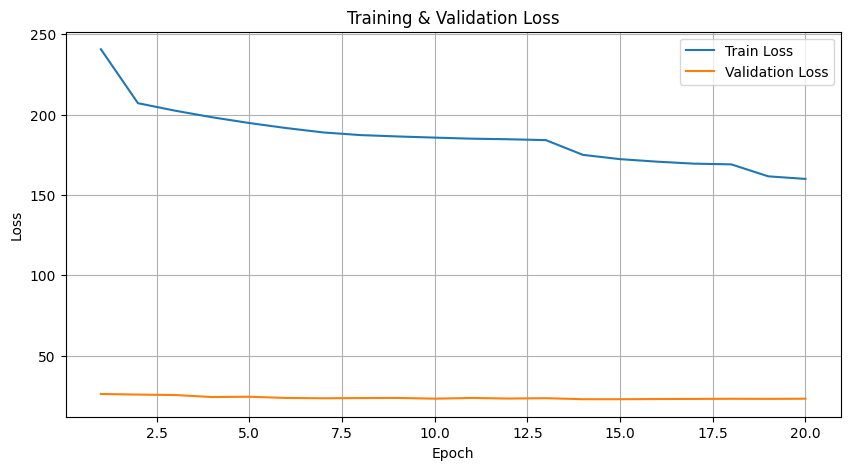

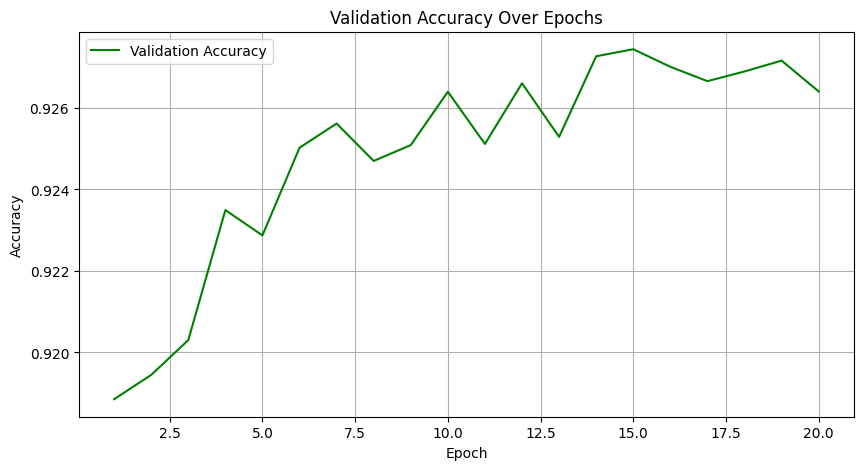

In [5]:
# === Imports & Setup ===
import os, re, torch, torch.nn as nn, torch.optim as optim
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MAX_LEN = 128
EMBED_DIM = 100
HIDDEN_DIM = 128
BATCH_SIZE = 128
EPOCHS = 50
LR = 1e-3
PATIENCE = 5

# === Load Data ===
train_df = pd.read_csv("train_clean_with_id.csv")
val_df = pd.read_csv("val_clean_with_id.csv")
test_df = pd.read_csv("test_clean_with_id.csv")

# ✅ FIX: Only use genre label columns (exclude text & non-binary)
label_cols = [col for col in train_df.columns if col not in ['id', 'overview', 'poster_path']]
train_df[label_cols] = train_df[label_cols].astype(float)
val_df[label_cols] = val_df[label_cols].astype(float)
test_df[label_cols] = test_df[label_cols].astype(float)

# === Tokenization & Vocabulary ===
def tokenize(text):
    return re.findall(r"\b\w+\b", str(text).lower())

counter = Counter()
for text in train_df["overview"]:
    counter.update(tokenize(text))

vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.items())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

# === Load GloVe Embeddings ===
def load_glove(path):
    embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != EMBED_DIM + 1:
                continue
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove_path = 'glove.6B.100d.txt'
print("Loading GloVe...")
glove_embeddings = load_glove(glove_path)
print(f"Loaded {len(glove_embeddings)} word vectors.")

embedding_matrix = torch.randn(len(vocab), EMBED_DIM)
glove_mean = np.mean(list(glove_embeddings.values()), axis=0)

for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = torch.tensor(glove_embeddings[word])
    else:
        embedding_matrix[idx] = torch.tensor(glove_mean)

# === Dataset and DataLoader ===
def encode(text):
    return torch.tensor([vocab.get(token, 1) for token in tokenize(text)], dtype=torch.long)

def collate_fn(batch):
    texts, labels = zip(*batch)
    encodings = [encode(text)[:MAX_LEN] for text in texts]
    padded = pad_sequence(encodings, batch_first=True, padding_value=0)
    label_tensor = torch.tensor(labels, dtype=torch.float)
    return padded, label_tensor

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe["overview"].tolist()
        self.labels = dataframe[label_cols].values.tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_loader = DataLoader(TextDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(val_df), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(TextDataset(test_df), batch_size=BATCH_SIZE, collate_fn=collate_fn)

# === Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, weights):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        self.embedding_dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding_dropout(self.embedding(x))
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.fc(self.dropout_fc(hidden))

model = LSTMClassifier(len(vocab), EMBED_DIM, HIDDEN_DIM, len(label_cols), embedding_matrix).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, min_lr=1e-6)

# === Training ===
train_losses, val_losses, val_accs = [], [], []
best_val_loss = float('inf')
wait = 0

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    model.train()
    total_loss = 0

    for x_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    # === Validation ===
    model.eval()
    val_loss, preds_list, targets_list = 0, [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            val_loss += criterion(output, y_batch).item()
            preds = (torch.sigmoid(output).cpu().numpy() >= 0.5).astype(int)
            preds_list.extend(preds.tolist())
            targets_list.extend(y_batch.cpu().numpy().tolist())

    preds_array = np.array(preds_list)
    targets_array = np.array(targets_list)
    acc_per_sample = (preds_array == targets_array).sum(axis=1) / targets_array.shape[1]
    val_acc = acc_per_sample.mean()

    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_multilabel_lstm_balanced.pt")
        print(" Best model saved!")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(" Early stopping.")
            break

# === Testing ===
model.load_state_dict(torch.load("best_multilabel_lstm_balanced.pt"))
model.eval()

test_preds, test_true = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        output = model(x_batch)
        preds = (torch.sigmoid(output).cpu().numpy() >= 0.5).astype(int)
        test_preds.extend(preds.tolist())
        test_true.extend(y_batch.tolist())

print("\n Test Classification Report:")
print(classification_report(test_true, test_preds, target_names=[str(c) for c in label_cols], zero_division=0))

# === Final Test Accuracy ===
test_preds_np = np.array(test_preds)
test_true_np = np.array(test_true)
correct_per_sample = (test_preds_np == test_true_np).sum(axis=1)
final_acc = (correct_per_sample / test_true_np.shape[1]).mean()
print(f"\nFinal Test Accuracy: {final_acc:.4f}")

# === Visualization ===
epochs_ran = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs_ran, train_losses, label='Train Loss')
plt.plot(epochs_ran, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_ran, val_accs, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# 1. Install dependencies (run once)
!pip install --quiet torch torchvision pandas scikit-learn matplotlib tqdm requests

# 2. Imports & device setup
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import requests

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [7]:
# 3. Download & balancing flags
DOWNLOAD_POSTERS = True            # set True once to fetch images
RAW_CSV = "train_clean_with_id.csv"
BAL_CSV = "balanced_train.csv"
IMG_DIR = "posters/balanced"
MAX_PER = 600                      # cap per-genre for speed

os.makedirs(IMG_DIR, exist_ok=True)

if DOWNLOAD_POSTERS:
    # create balanced subset
    if not os.path.isfile(RAW_CSV):
        raise FileNotFoundError(f"Raw CSV '{RAW_CSV}' not found; upload first.")
    df = pd.read_csv(RAW_CSV)
    label_cols = [c for c in df.columns if c not in ['id','overview','poster_path']]
    frames = []
    for g in label_cols:
        sub = df[df[g]==1]
        frames.append(sub.sample(n=min(len(sub),MAX_PER), random_state=42))
    bal_df = pd.concat(frames).drop_duplicates('id').reset_index(drop=True)
    bal_df.to_csv(BAL_CSV, index=False)
    print(f"Created balanced subset with {len(bal_df)} samples in '{BAL_CSV}'")

    # download posters
    print(f"⬇️ Downloading {len(bal_df)} posters to {IMG_DIR}...")
    count = 0
    for _, row in tqdm(bal_df.iterrows(), total=len(bal_df)):
        pid, path = int(row['id']), row['poster_path']
        if not path: continue
        out = os.path.join(IMG_DIR, f"{pid}.jpg")
        if os.path.isfile(out): continue
        url = f"https://image.tmdb.org/t/p/w500{path}"
        try:
            r = requests.get(url, timeout=5)
            if r.status_code==200:
                open(out,'wb').write(r.content)
                count += 1
        except: pass
    print(f"✅ Downloaded {count} posters.")
else:
    if not os.path.isfile(BAL_CSV):
        raise FileNotFoundError(f"Balanced CSV '{BAL_CSV}' not found; set DOWNLOAD_POSTERS=True once.")
    print(f"Using existing images in '{IMG_DIR}'")

Created balanced subset with 10768 samples in 'balanced_train.csv'
⬇️ Downloading 10768 posters to posters/balanced...


100%|██████████| 10768/10768 [23:39<00:00,  7.59it/s]

✅ Downloaded 10767 posters.


In [8]:
# 4. Transforms: stronger augmentation + evaluation pipeline
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomErasing(p=0.1, scale=(0.02,0.33), ratio=(0.3,3.3), value='random'),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])



In [9]:
# 5. Dataset class
class PosterDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        df = pd.read_csv(csv_file)
        self.label_cols = [c for c in df.columns if c not in ['id','overview','poster_path']]
        df = df[df['id'].apply(lambda x: os.path.isfile(os.path.join(image_dir,f"{int(x)}.jpg")))].reset_index(drop=True)
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.image_dir,f"{int(row['id'])}.jpg")).convert('RGB')
        if self.transform: img = self.transform(img)
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        return img, labels



In [10]:
# 6. DataLoaders + splits
torch.manual_seed(42)
dataset = PosterDataset(BAL_CSV, IMG_DIR)
if len(dataset)==0:
    raise RuntimeError("No images found; check downloads.")
print(f"Loaded {len(dataset)} samples.")

total = len(dataset)
train_size = int(0.8*total)
val_size   = int(0.1*total)
test_size  = total-train_size-val_size
train_ds, val_ds, test_ds = random_split(dataset,[train_size,val_size,test_size], generator=torch.Generator().manual_seed(42))
# override transforms after split
train_ds.dataset.transform = train_transform
val_ds.dataset.transform   = val_transform
test_ds.dataset.transform  = val_transform

batch_size = 64
# Use single worker and disable pin_memory to prevent loader deadlocks/hangs
dl_args = dict(batch_size=batch_size, num_workers=0, pin_memory=False)

train_loader = DataLoader(train_ds, shuffle=True, **dl_args)
val_loader   = DataLoader(val_ds, shuffle=False, **dl_args)
test_loader  = DataLoader(test_ds, shuffle=False, **dl_args)

Loaded 10767 samples.


In [11]:
# 7. Model & head + partial freeze
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for n,p in model.named_parameters():
    if not any(n.startswith(l) for l in ['layer3','layer4','fc']): p.requires_grad=False
num_classes = len(dataset.label_cols)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,num_classes)
)
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


In [12]:
# 8. Loss, optimizer, scheduler, mixup
criterion      = nn.BCEWithLogitsLoss()
mixup_alpha    = 0.2
epochs         = 10
optimizer      = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr=1e-3)
scheduler      = OneCycleLR(
    optimizer, max_lr=1e-3, epochs=epochs,
    steps_per_epoch=len(train_loader), pct_start=0.3,
    anneal_strategy='cos', div_factor=25.0
)
scaler         = GradScaler()
best_val_loss  = float('inf')
patience, max_patience = 0, 2

def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha) if alpha>0 else 1.0
    idx = torch.randperm(x.size(0))
    mixed_x = lam*x + (1-lam)*x[idx]
    mixed_y = lam*y + (1-lam)*y[idx]
    return mixed_x, mixed_y

<ipython-input-12-d9cb1816b5be>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler         = GradScaler()


In [13]:
# 9. Train & eval

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for imgs, lbls in tqdm(train_loader, desc='Train'):
        imgs, lbls = imgs.to(device), lbls.to(device)
        # mixup
        if mixup_alpha>0:
            imgs, lbls = mixup_data(imgs, lbls, mixup_alpha)
        optimizer.zero_grad()
        with autocast(): out = model(imgs); loss = criterion(out, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()*imgs.size(0)
    return running_loss/total


def evaluate(loader):
    model.eval()
    running_loss=0.0; all_t, all_p = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            preds = (torch.sigmoid(out)>0.5).cpu().numpy()
            all_p.append(preds); all_t.append(lbls.cpu().numpy())
    return running_loss/total, np.vstack(all_t), np.vstack(all_p)



In [14]:
# 10. Training loop with batch-level progress
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for batch_idx, (imgs, lbls) in enumerate(pbar, start=1):
        imgs, lbls = imgs.to(device), lbls.to(device)
        if mixup_alpha>0:
            imgs, lbls = mixup_data(imgs, lbls, mixup_alpha)
        optimizer.zero_grad()
        with autocast():
            out = model(imgs)
            loss = criterion(out, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()*imgs.size(0)
        avg_loss = running_loss/(batch_idx*imgs.size(0))
        pbar.set_postfix({'avg_loss': f"{avg_loss:.4f}"})
    tr_loss = running_loss/total
    val_loss, yv, yp = evaluate(val_loader)
    print(f"Epoch {epoch}: train={tr_loss:.4f}, val={val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss, patience = val_loss, 0
        torch.save(model.state_dict(),'best.pth')
    else:
        patience += 1
        if patience >= max_patience:
            print("Early stopping.")
            break


Epoch 1 Train:   0%|          | 0/135 [00:00<?, ?it/s]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Train:   1%|          | 1/135 [00:01<02:20,  1.05s/it, avg_loss=0.7119]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Train:   1%|▏         | 2/135 [00:01<01:45,  1.26it/s, avg_loss=0.7106]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Train:   2%|▏         | 3/135 [00:02<01:31,  1.44it/s, avg_loss=0.7082]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(

Epoch 1: train=0.3773, val=0.0338


Epoch 2 Train:   0%|          | 0/135 [00:00<?, ?it/s]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 Train:   1%|          | 1/135 [00:00<01:19,  1.69it/s, avg_loss=0.3485]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 Train:   1%|▏         | 2/135 [00:01<01:16,  1.73it/s, avg_loss=0.3750]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 Train:   2%|▏         | 3/135 [00:01<01:16,  1.72it/s, avg_loss=0.3662]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(

Epoch 2: train=0.2779, val=0.0337


Epoch 3 Train:   0%|          | 0/135 [00:00<?, ?it/s]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 Train:   1%|          | 1/135 [00:00<01:20,  1.66it/s, avg_loss=0.3368]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 Train:   1%|▏         | 2/135 [00:01<01:19,  1.68it/s, avg_loss=0.3276]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 Train:   2%|▏         | 3/135 [00:01<01:17,  1.70it/s, avg_loss=0.3384]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(

Epoch 3: train=0.2670, val=0.0337


Epoch 4 Train:   0%|          | 0/135 [00:00<?, ?it/s]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 Train:   1%|          | 1/135 [00:00<01:18,  1.71it/s, avg_loss=0.3295]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 Train:   1%|▏         | 2/135 [00:01<01:16,  1.73it/s, avg_loss=0.3240]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 Train:   2%|▏         | 3/135 [00:01<01:15,  1.76it/s, avg_loss=0.3201]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(

Epoch 4: train=0.2549, val=0.0346


Epoch 5 Train:   0%|          | 0/135 [00:00<?, ?it/s]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 Train:   1%|          | 1/135 [00:00<01:17,  1.72it/s, avg_loss=0.2810]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 Train:   1%|▏         | 2/135 [00:01<01:17,  1.71it/s, avg_loss=0.2804]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 Train:   2%|▏         | 3/135 [00:01<01:16,  1.72it/s, avg_loss=0.2924]<ipython-input-14-43c65a59a91f>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(

Epoch 5: train=0.2364, val=0.0367
Early stopping.


Micro F1: 0.182616881079385
Macro F1: 0.1243567547095405
Precision: 0.6510067114093959
Recall: 0.1062043795620438


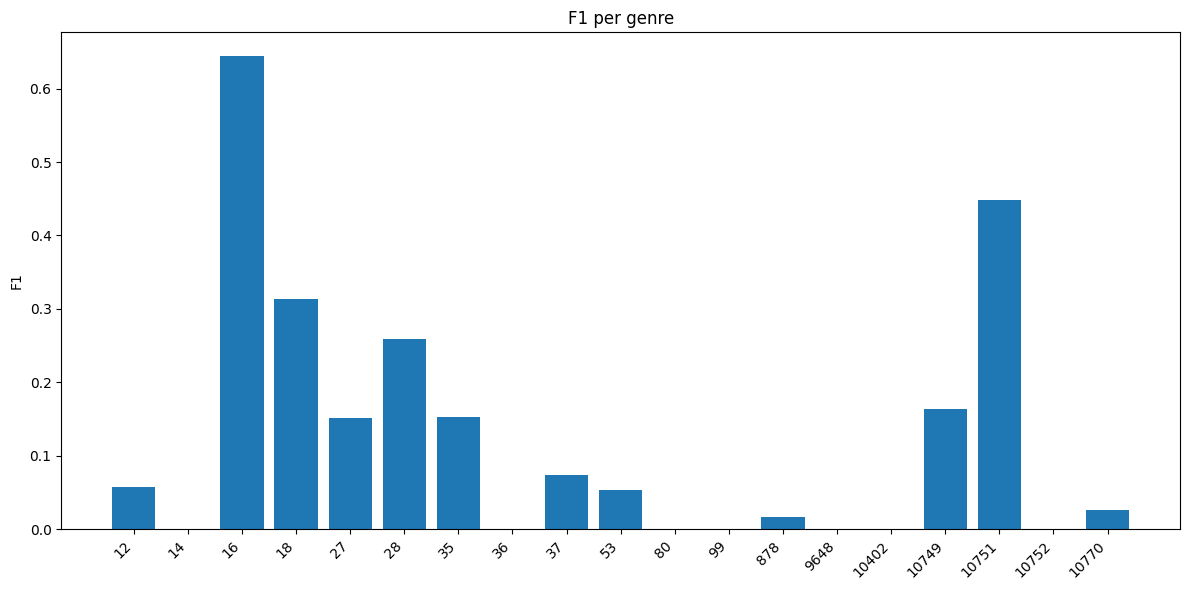

In [15]:
# 11. Test metrics
model.load_state_dict(torch.load('best.pth'))
_, yt, yp = evaluate(test_loader)
print("Micro F1:", f1_score(yt, yp, average='micro'))
print("Macro F1:", f1_score(yt, yp, average='macro'))
print("Precision:", precision_score(yt, yp, average='micro'))
print("Recall:", recall_score(yt, yp, average='micro'))

# 12. Plot per-genre F1
f1s = f1_score(yt, yp, average=None)
plt.figure(figsize=(12,6))
plt.bar(range(num_classes), f1s)
plt.xticks(range(num_classes), dataset.label_cols, rotation=45, ha='right')
plt.ylabel('F1'); plt.title('F1 per genre'); plt.tight_layout(); plt.show()


In [19]:
# Some prerequisites for before the tasks of Role-4

import os
import random
import numpy as np
import torch
import pandas as pd

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score

# 1. Freeze seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 2. Automate requirements.txt generation (once)
if not os.path.exists('requirements.txt'):
    os.system('pip install requests pandas torch torchvision transformers scikit-learn tqdm wandb')
    os.system('pip freeze > requirements.txt')
    print("Generated requirements.txt")
else:
    print("requirements.txt already exists, skipping")

# Paths & filenames
TEXT_CSV    = 'train_clean_with_id.csv'
IMG_CSV     = 'balanced_train.csv'
IMG_DIR     = 'posters/balanced'
MERGED_CSV  = 'merged_multimodal.csv'

# 3. Merge text & image CSVs; drop missing/misaligned rows
df_text = pd.read_csv(TEXT_CSV)
df_img  = pd.read_csv(IMG_CSV)
# ensure integer IDs
df_img['id'] = df_img['id'].astype(int)

# vectorized existence check
exists = [os.path.isfile(os.path.join(IMG_DIR, f"{pid}.jpg")) for pid in df_img['id']]
df_img = df_img.loc[exists, ['id','poster_path']]

merged = pd.merge(df_text, df_img, on='id', how='inner')
merged.to_csv(MERGED_CSV, index=False)
print(f"Merged dataset: {len(merged)} samples → {MERGED_CSV}")

# label columns
label_cols = [c for c in merged.columns if c not in ['id','overview','poster_path']]

# 4. Quantify imbalance & compute clipped pos_weight for BCEWithLogitsLoss

# infer label columns by selecting only numeric fields (and dropping the 'id' key)
label_columns = (
    merged
    .select_dtypes(include=[np.number])   # keep only numeric dtypes
    .columns
    .drop('id')                           # drop the sample ID itself
    .tolist()
)

# sum up positives per class
class_counts  = merged[label_columns].sum()

# total number of examples
total_samples = merged.shape[0]

# compute positive‐weight and clip to avoid extremes
pos_weight    = (total_samples - class_counts) / class_counts
pos_weight    = pos_weight.clip(upper=10)

print("Clipped pos_weight:\n", pos_weight.to_dict())

# 5. Define image transforms & a simple text-dropout fn
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def token_dropout(tokens, drop_prob=0.1):
    """drop each token independently with probability=drop_prob"""
    return [t for t in tokens if random.random() > drop_prob]

# 6. Verify GPU memory headroom (batch=64, 30 GB threshold)
if torch.cuda.is_available():
    class DummyDataset(Dataset):
        def __len__(self): return 64
        def __getitem__(self, idx):
            img   = torch.randn(3,224,224, device='cuda')
            txt   = torch.randint(0,1000,(128,), device='cuda')
            label = torch.zeros(len(label_cols), device='cuda')
            return img, txt, label

    dl = DataLoader(DummyDataset(), batch_size=64)
    for imgs, txts, labs in dl:
        mb = torch.cuda.memory_allocated() / 1024**2
        print(f"GPU alloc (MB): {mb:.0f}")
        if mb > 30*1024:
            raise MemoryError("❌ >30 GB used — reduce batch size or enable grad-accum")
        break

# 7. Set up AMP scaler
scaler = torch.cuda.amp.GradScaler()

# 8. Metrics helper
def compute_metrics(y_true, y_pred):
    """
    y_true, y_pred: np arrays of shape (N, num_classes), binary
    returns dict with micro/macro F1, precision, recall, per-class F1
    """
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    per_cls  = f1_score(y_true, y_pred, average=None)
    prec     = precision_score(y_true, y_pred, average='micro')
    rec      = recall_score(y_true, y_pred, average='micro')
    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'per_class_f1': dict(zip(label_cols, per_cls)),
        'precision': prec,
        'recall': rec
    }

# 9. Threshold & early-stopping docs
GLOBAL_THRESHOLD   = 0.5
EARLY_STOP_PATIENCE = 3  # Between Role-2’s 5 and Role-3’s 2, tuned for A100

# 10. WandB init (run once, then comment out)
import wandb
# wandb.init(project='multi_modal_genre', name='role4_setup')
print("WandB ready; comment out init after first run")

# 11. Conditional checkpoint saving by best_val_f1
best_val_f1 = -float('inf')

def save_checkpoint(model, epoch, val_f1, folder='checkpoints'):
    global best_val_f1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        os.makedirs(folder, exist_ok=True)
        fname = f"{folder}/mm_epoch{epoch}_valF1{val_f1:.3f}.pt"
        torch.save(model.state_dict(), fname)
        print(f"Saved checkpoint: {fname}")

# 12. Smoke-test: overfit tiny batch to catch pipeline errors
class SmokeDataset(Dataset):
    def __init__(self, df): self.df = df.sample(8, random_state=42)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        # return dummy image, dummy tokens, dummy labels
        return (
            torch.randn(3,224,224),
            torch.randint(0,1000,(128,)),
            torch.zeros(len(label_cols))
        )

smoke_dl   = DataLoader(SmokeDataset(merged), batch_size=8)
dummy_model = torch.nn.Linear(1, len(label_cols)).cuda()
optimizer   = torch.optim.Adam(dummy_model.parameters(), lr=0.01)

print("Running smoke test")
for epoch in range(2):
    for imgs, txts, labs in smoke_dl:
        imgs, txts, labs = imgs.cuda(), txts.cuda(), labs.cuda()
        with torch.cuda.amp.autocast():
            # fake forward
            out = dummy_model(torch.ones(imgs.size(0),1, device='cuda'))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(out, labs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        print(f"  epoch {epoch} loss: {loss.item():.4f}")
        break

print("Pre_role4_setup complete — you’re ready for Role-4!")


requirements.txt already exists, skipping
Merged dataset: 10767 samples → merged_multimodal.csv
Clipped pos_weight:
 {'12': 6.864864864864865, '14': 7.690072639225182, '16': 6.905286343612334, '18': 1.8904697986577181, '27': 6.729361091170136, '28': 4.4078352586639875, '35': 3.412704918032787, '36': 10.0, '37': 10.0, '53': 5.028555431131019, '80': 7.876339653751031, '99': 6.734913793103448, '878': 8.24206008583691, '9648': 9.82110552763819, '10402': 10.0, '10749': 6.911094783247612, '10751': 7.340046475600309, '10752': 10.0, '10770': 7.282307692307692}
GPU alloc (MB): 229
WandB ready; comment out init after first run
Running smoke test
  epoch 0 loss: 0.8408
  epoch 1 loss: 0.8300
Pre_role4_setup complete — you’re ready for Role-4!


<ipython-input-19-baf561466e5e>:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-19-baf561466e5e>:168: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [35]:
# === Role-4: Multi-Modal Fusion & Training ===

# 1. Environment & Installs (if needed)
# !pip install torch torchvision pandas numpy scikit-learn tqdm wandb

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# 2. Fix random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 3. Load merged CSV & compute label columns & pos_weight
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MERGED_CSV = "merged_multimodal.csv"
IMG_DIR    = "posters/balanced"

df = pd.read_csv(MERGED_CSV)

non_label_cols = ["id", "overview", "poster_path", "filename"]
potential      = [c for c in df.columns if c not in non_label_cols]
label_cols     = [c for c in potential if pd.api.types.is_numeric_dtype(df[c])]

df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)

class_counts  = df[label_cols].sum()
total_samples = len(df)
pos_weight    = ((total_samples - class_counts) / class_counts).clip(upper=10).values
pos_weight    = torch.tensor(pos_weight, dtype=torch.float, device=device)
print("✔ pos_weight computed and clipped.")

# 4. Build vocab & load GloVe … (from your Role-2 code)
#    assume vocab, embedding_matrix, EMBED_DIM, MAX_LEN exist

# 5. Transforms & augmentation
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def token_dropout(tokens, drop_prob=0.1):
    return [t for t in tokens if random.random() > drop_prob]

# 6. Dataset & DataLoader
class MultiModalDataset(Dataset):
    def __init__(self, df, img_dir, vocab, max_len, transform=None):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.vocab     = vocab
        self.max_len   = max_len
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row.get("filename", f"{int(row['id'])}.jpg")
        img   = Image.open(os.path.join(self.img_dir, str(fname))).convert("RGB")
        if self.transform:
            img = self.transform(img)
        tokens = row["overview"].split()
        tokens = token_dropout(tokens)
        ids    = [self.vocab.get(t, self.vocab["<unk>"]) for t in tokens][:self.max_len]
        ids   += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        txt    = torch.tensor(ids, dtype=torch.long)
        lbls   = row[label_cols].values
        labels = torch.tensor([float(x) for x in lbls], dtype=torch.float)
        return img, txt, labels

train_df, rest     = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)
val_df, test_df    = train_test_split(rest, test_size=0.5, random_state=SEED, shuffle=True)

train_ds = MultiModalDataset(train_df, IMG_DIR, vocab, MAX_LEN, transform=train_transform)
val_ds   = MultiModalDataset(val_df,   IMG_DIR, vocab, MAX_LEN, transform=train_transform)
test_ds  = MultiModalDataset(test_df,  IMG_DIR, vocab, MAX_LEN, transform=train_transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# 7. Fusion model
import torchvision.models as models

class MultiModalFusion(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, embedding_matrix, pos_weight):
        super().__init__()
        self.embedding  = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm       = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.text_proj  = nn.Linear(hidden_dim*2, 128)

        self.resnet     = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for p in self.resnet.parameters(): p.requires_grad = False
        self.resnet.fc  = nn.Identity()
        self.image_proj = nn.Linear(512, 128)

        self.fc         = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, imgs, txts, labels=None):
        x = self.embedding(txts)
        _, (h, _) = self.lstm(x)
        txt_feat = self.text_proj(torch.cat((h[-2], h[-1]), dim=1))
        img_feat = self.image_proj(self.resnet(imgs))
        fused    = torch.cat((txt_feat, img_feat), dim=1)
        logits   = self.fc(fused)
        if labels is not None:
            return logits, self.criterion(logits, labels)
        return logits

model = MultiModalFusion(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=128,
    num_classes=len(label_cols),
    embedding_matrix=embedding_matrix,
    pos_weight=pos_weight
).to(device)

# 8. Optimizer, Scheduler, Scaler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=20,
    steps_per_epoch=len(train_loader),
    pct_start=0.3
)
scaler = torch.cuda.amp.GradScaler()

# 9. Metrics util
def compute_metrics(y_t, y_p):
    micro = f1_score(y_t, y_p, average='micro')
    macro = f1_score(y_t, y_p, average='macro')
    prec  = precision_score(y_t, y_p, average='micro')
    rec   = recall_score(y_t, y_p, average='micro')
    return micro, macro, prec, rec

# 10. Checkpointing
best_val_f1 = -float('inf')
def save_ckpt(epoch, val_f1):
    global best_val_f1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        os.makedirs('checkpoints', exist_ok=True)
        fn = f"checkpoints/mm_epoch{epoch}_valF1{val_f1:.3f}.pt"
        torch.save(model.state_dict(), fn)
        print(f"✔ Saved {fn}")

# 11. Training loop
epochs, patience, max_patience = 20, 0, 3
for epoch in range(1, epochs+1):
    model.train(); total_loss = 0.0
    for imgs, txts, labs in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, txts, labs = imgs.to(device), txts.to(device), labs.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits, loss = model(imgs, txts, labs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    scheduler.step()

    # Validation
    model.eval(); all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, txts, labs in val_loader:
            imgs, txts = imgs.to(device), txts.to(device)
            logits     = model(imgs, txts)
            preds      = (torch.sigmoid(logits).cpu().numpy() >= 0.5).astype(int)
            all_preds.append(preds)
            all_targets.append(labs.numpy().astype(int))
    y_pred = np.vstack(all_preds); y_true = np.vstack(all_targets)
    micro, macro, prec, rec = compute_metrics(y_true, y_pred)
    print(f"→ Val Epoch {epoch}: loss={total_loss/len(train_loader):.4f}, "
          f"micro-F1={micro:.4f}, macro-F1={macro:.4f}")
    save_ckpt(epoch, micro)

    if micro > best_val_f1:
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print("⚠ Early stopping triggered.")
            break

print("✅ Role-4 training complete.")


✔ pos_weight computed and clipped.


<ipython-input-35-2695cf4a15e7>:154: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]<ipython-input-35-2695cf4a15e7>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


→ Val Epoch 1: loss=1.1676, micro-F1=0.2616, macro-F1=0.2142
✔ Saved checkpoints/mm_epoch1_valF10.262.pt


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]<ipython-input-35-2695cf4a15e7>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s]


→ Val Epoch 2: loss=1.1591, micro-F1=0.2949, macro-F1=0.2515
✔ Saved checkpoints/mm_epoch2_valF10.295.pt


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]<ipython-input-35-2695cf4a15e7>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s]


→ Val Epoch 3: loss=1.1502, micro-F1=0.3114, macro-F1=0.2732
✔ Saved checkpoints/mm_epoch3_valF10.311.pt
⚠ Early stopping triggered.
✅ Role-4 training complete.
